In [54]:
import string
import os

import pandas as pd
from pandas import to_pickle, read_pickle
from sklearn.metrics import accuracy_score, \
    precision_score, \
    recall_score, \
    ConfusionMatrixDisplay, \
    f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import re
import matplotlib.pyplot as plt

In [55]:
#Function to load the data from the dataset into the notebook. Will be called twice - for train and test.
def get_data(data_dir):
    texts = []  # list of text samples
    labels_index = {'pos':1, 'neg':0}  # dictionary mapping label name to numeric id
    tone = []
    score = []
    for name in sorted(os.listdir(data_dir)):
        path = os.path.join(data_dir, name)
        if os.path.isdir(path):
            if name=='pos' or name=='neg':
                label_id = labels_index[name]
                for fname in sorted(os.listdir(path)):
                        fpath = os.path.join(path, fname)
                        text = open(fpath,encoding='utf8').read()
                        texts.append(text)
                        tone.append(label_id)
                        score.append(re.search("_(\d+)",fname)[1])
    return texts, tone, score

X_train, y1_tone_train, y2_score_train = get_data('aclImdb/train')
X_test, y1_tone_test, y2_score_test = get_data('aclImdb/test')

In [56]:
print(X_train[24990])
print(y1_tone_train[24990])
print(y2_score_train[24990])

The most hillarious and funny Brooks movie I ever seen. I can watch and re-watch the tape 100 times. I laugh my a** off and I cry on some moments. It is really good and funny movie, and if you like Brooks - this is a must! In short - Brooks (billionare) gets to the streets as homeless for 30 days in order to win the entire poor district from his competitor. The reality bites, but in the end - it is about warm relations between humans... Hightly recommend!
1
10


In [57]:
stemmer = SnowballStemmer(language="english")
stop_words = stopwords.words("english")

def review_to_tokens(review):
    tokens = word_tokenize(review, language="english")
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [i for i in tokens if i not in stop_words]
    tokens = [stemmer.stem(i) for i  in tokens]
    return tokens

In [58]:
vectorizer = TfidfVectorizer(tokenizer=review_to_tokens)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [59]:
tone_classifier = LogisticRegression(penalty="l2", random_state=42, C=1.2, solver="saga")
tone_model = tone_classifier.fit(X_train, y1_tone_train)
y1_tone_pred = tone_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

0.881457749299159
0.8804
0.881


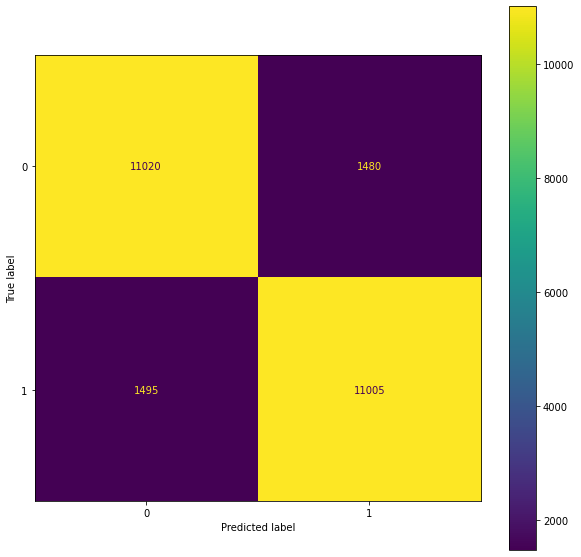

In [67]:
import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

print(classification_report(y_true=y1_tone_test, y_pred=y1_tone_pred))
print(precision_score(y_true=y1_tone_test, y_pred=y1_tone_pred))
print(recall_score(y_true=y1_tone_test, y_pred=y1_tone_pred))
print(accuracy_score(y_true=y1_tone_test, y_pred=y1_tone_pred))
ConfusionMatrixDisplay.from_predictions(y_true=y1_tone_test, y_pred=y1_tone_pred)
plt.savefig("Graphs/tone_confusion_matrix.png")
plt.show()

In [ ]:
y_probas = tone_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y1_tone_test, y_probas)
plt.savefig("Graphs/roc_auc_curve_tone.png")
plt.show()

In [69]:
temp_score = y2_score_train

def cut_n (y_train, n, target):
    target_indxs = []
    for i in range(len(y_train)):
        if int(y2_score_train[i]) == target:
            target_indxs.append(i)
    return target_indxs[n:]

indxs = [*cut_n(y2_score_train, 3000, 10), *cut_n(y2_score_train, 3000, 1)]

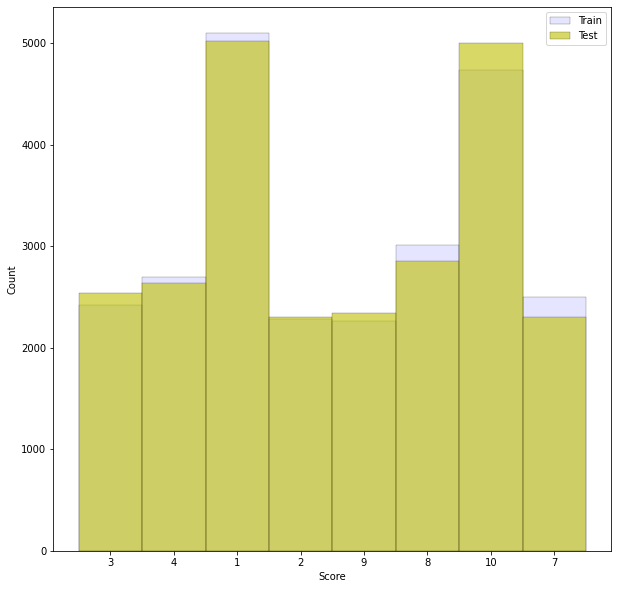

In [70]:
import seaborn as sns

sns.histplot(data=y2_score_train,
            fill=True,
            alpha=0.1,
            palette="crest",
            color="b",
            linewidth=0.2
             )
sns.histplot(data=y2_score_test,
            fill=True,
            alpha=0.6,
            color="y",
            linewidth=0.2
             )
plt.legend(["Train", "Test"])
plt.xlabel("Score")
plt.rcParams["figure.figsize"] = (10,10)
plt.savefig("Graphs/score_test_hist.png")
plt.show()

In [71]:
from sklearn.metrics import log_loss
from sklearn.svm import SVC
score_classifier = LogisticRegression(penalty="l2", random_state=42, C=1, solver="saga")
#score_classifier = SVC(kernel="linear", C=1.5, random_state=42)
score_model = score_classifier.fit(X_train, y2_score_train)
y2_score_pred = score_model.predict(X_test)

0.44204


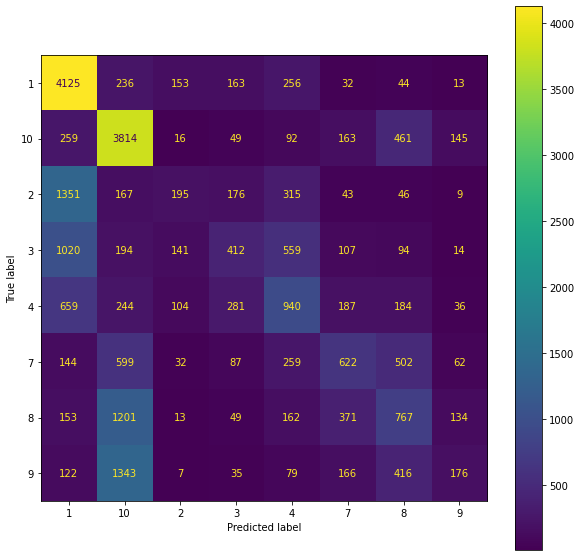

In [72]:
#print(log_loss(y_true=y2_score_test, y_pred=y2_score_pred))
print(f1_score(y_true=y2_score_test, y_pred=y2_score_pred, average="micro"))
ConfusionMatrixDisplay.from_predictions(y_true=y2_score_test, y_pred=y2_score_pred)
plt.savefig("Graphs/score_confusion_matrix.png")
plt.show()

In [73]:
#to_pickle(vectorizer.vocabulary_, "vect_vocab.pkl")
#to_pickle(tone_model, "tone_model.pkl")
to_pickle(score_model, "score_model.pkl")

In [74]:
print(score_model.predict(vectorizer.transform(["Great!"])))

['10']


In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
import scikitplot as skplt
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true=y2_score_test, y_score=score_model.predict_proba(X_test), multi_class='ovr'))
y_true = y2_score_test
y_probas = score_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.savefig("Graphs/roc_auc_curve_score.png")
plt.show()

